# BigQuery: column value distribution

## setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gcp_key = '../../etc/prod-ostro/gcp.json'
gcp_project = 'zephyrus-ef4-prod-ostro'
bq_dataset = 'ostro'

### misc functions

In [4]:
def ppsql(sql_string):
    print(sql_string.strip())

## sql functions

In [5]:
def create_base(table_id, column_name, timestamp='timestamp'):
    return """
    derived_base AS (
        SELECT
            format_date('%Y%m%d', DATE({timestamp})) as event_day,
            extract(hour from {timestamp}) as event_hour,
            {column} AS event_column
        FROM {table}
        WHERE _PARTITIONTIME BETWEEN TIMESTAMP('2017-09-04 00:00:00')
                                 AND TIMESTAMP('2017-09-10 00:00:00')
        )
    """.format(table=table_id, column=column_name, timestamp=timestamp)

In [6]:
def create_base_percentile(table_id, column_name, timestamp='timestamp'):
    return """
    percentiles AS (
        SELECT
            APPROX_QUANTILES({column}, 20) AS ptiles
        FROM {table}
        ),
    
    outlier_percentiles AS (
        SELECT
            ptiles[OFFSET(1)] AS ptile_lower,
            ptiles[OFFSET(ARRAY_LENGTH(ptiles)-2)] AS ptile_upper
        FROM percentiles
        ),
    
    derived_base AS (
        SELECT
            format_date('%Y%m%d', DATE({timestamp})) as event_day,
            extract(hour from {timestamp}) as event_hour,
            {column} AS event_column
        FROM {table}
        WHERE _PARTITIONTIME BETWEEN TIMESTAMP('2017-09-04 00:00:00')
                                 AND TIMESTAMP('2017-09-10 00:00:00')
        AND {column} > (SELECT ptile_lower FROM outlier_percentiles)
        AND {column} < (SELECT ptile_upper FROM outlier_percentiles)
        )
    """.format(table=table_id, column=column_name, timestamp=timestamp)

In [7]:
def create_bool_convert():
    return """
    derived_number AS (
        SELECT
            event_day,
            event_hour,
            CASE event_column
            WHEN true  THEN 0.75
            WHEN false THEN 0.25
            END AS number_column
        FROM derived_base
        )
    """

In [8]:
def create_time_convert():
    return """
    derived_number AS (
        SELECT
            event_day,
            event_hour,
            UNIX_SECONDS(event_column) AS number_column
        FROM derived_base
        )
    """

In [9]:
def create_number_convert():
    return """
    derived_number AS (
        SELECT
            event_day,
            event_hour,
            event_column AS number_column
        FROM derived_base
        )
    """

In [10]:
def create_string_convert(slice_size=5):
    if slice_size >= 0:
        substr_parameters = "event_column,0,{no_characters}".format(no_characters=slice_size)
    else:
        substr_parameters = "reverse(event_column),0,{no_characters}".format(no_characters=(-1*slice_size))

    return """
    string_substr AS (
        SELECT
            event_day,
            event_hour,
            SUBSTR({parameters}) AS string_column
        FROM derived_base
        ),

    derived_number AS (
        SELECT
            event_day,
            event_hour,
            CAST(CONCAT('0x', SUBSTR(TO_HEX(MD5(string_column)),0,15)) AS INT64) AS number_column
        FROM string_substr
        )
    """.format(parameters=substr_parameters)

In [11]:
def create_hash_convert():
    return """
    derived_number AS (
        SELECT
            event_day,
            event_hour,
            STRTOL(SUBSTRING(event_column,0,15), 16) AS number_column
        FROM derived_base
        WHERE regexp_count(event_column, '[ABCDEF0123456789]') = length(event_column)
        )
    """

In [12]:
def create_stats():
    return """
    derived_stats AS (
        SELECT
            min(number_column) AS min_value,
            max(number_column) AS max_value,
            max(number_column) - min(number_column) AS range_value,
            avg(number_column) AS mean_value
        FROM derived_number
        WHERE number_column > 0
        ),

    derived_norm AS (
        SELECT
            event_day,
            event_hour,
            number_column as raw_value,
            (CAST(number_column AS float64) - (SELECT min_value from derived_stats))
                / (SELECT range_value from derived_stats)
            AS normed_value
        FROM derived_number
        )
    """

In [13]:
def create_normed(sql_base):
    return """
    WITH
    {base}

    SELECT
        event_day,
        event_hour,
        raw_value,
        normed_value
    FROM derived_norm
    """.format(base=sql_base)

In [14]:
def create_column_stats(sql_base):
    return """
    WITH
    {base}

    SELECT
        min_value,
        max_value,
        range_value
    FROM derived_stats
    """.format(base=sql_base)

In [15]:
def create_normed_percentiles(sql_base):
    queries = []
    idx = 0
    for tile in np.linspace(0.0, 1.0, num=21):
        queries.append("""
            SELECT
            {tile:.2f} AS ptile,
            ptiles[OFFSET({index})] as ptile_value
            FROM derived_percentiles
            """.format(tile=tile, index=idx))
        idx += 1
    ptile_sql = ' UNION ALL '.join(queries)
    
    return """
    WITH
    {base},
    derived_percentiles AS (
        SELECT
            APPROX_QUANTILES(normed_value, 20) AS ptiles
        FROM derived_norm
        )
    
    {ptiles}
    """.format(ptiles=ptile_sql, base=sql_base)

## plot functions

In [16]:
def plot_one_per_day_overlay(df):
    sns.set(style="white", palette="muted")
    f, axes = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
    sns.despine(left=True)

    b, g, r, p = sns.color_palette("muted", 4)

    for d in df['event_day'].unique():
        if int(d) % 2 == 0: c=g
        else: c=b
        sns.distplot(df[(df['event_day'] == d)]['normed_value'], color=c)

    plt.tight_layout()

In [17]:
def plot_one_hour(df, bins=20):
    df[(df['event_day'] == '20170906') & (df['event_hour'] == 12)]['normed_value'].plot.hist(bins)

In [18]:
def plot_all(df, bins=20):
    df['normed_value'].plot.hist(bins)

In [19]:
def plot_raw_all(df, bins=20):
    df['raw_value'].plot.hist(bins)

In [30]:
def plot_cumul_all(df):
    sns.distplot(df['normed_value'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

## distribution of string values

In [20]:
table = '.'.join([bq_dataset, 'power_out'])

In [21]:
sql_prepare = ','.join([create_base(table, 'model'),
                        create_string_convert(),
                        create_stats()])

In [ ]:
df = pd.read_gbq(create_normed(sql_prepare),
                 dialect = 'standard',
                 project_id = gcp_project,
                 private_key = gcp_key)

In [ ]:
df_stats = pd.read_gbq(create_column_stats(sql_prepare),
                        dialect = 'standard',
                        project_id = gcp_project,
                        private_key = gcp_key)

In [24]:
df_stats

,min_value,max_value,range_value
0,738747573228445,1151708196245399645,1150969448672171200


In [25]:
df[:5]

,event_day,event_hour,raw_value,normed_value
0,20170909,17,626881450821167126,0.544013
1,20170909,17,626881450821167126,0.544013
2,20170909,17,626881450821167126,0.544013
3,20170909,17,626881450821167126,0.544013
4,20170909,17,626881450821167126,0.544013


### quantiles

In [ ]:
df_percentiles = pd.read_gbq(
                     create_normed_percentiles(sql_prepare),
                     dialect = 'standard',
                     project_id = gcp_project,
                     private_key = gcp_key)

In [27]:
df_percentiles.sort_values('ptile')

,ptile,ptile_value
0,0.00,0.000000
14,0.05,0.117436
13,0.10,0.201602
20,0.15,0.204471
2,0.20,0.283792
16,0.25,0.356066
11,0.30,0.453089
12,0.35,0.453089
18,0.40,0.531790
9,0.45,0.544013


In [28]:
df.quantile(np.linspace(0.0, 1.0, num=21))

,event_hour,raw_value,normed_value
0.00,0.0,7.387476e+14,0.000000
0.05,1.0,1.359040e+17,0.117436
0.10,2.0,2.327771e+17,0.201602
0.15,3.0,2.360785e+17,0.204471
0.20,5.0,3.273744e+17,0.283792
0.25,6.0,4.105597e+17,0.356066
0.30,7.0,5.222304e+17,0.453089
0.35,9.0,5.222304e+17,0.453089
0.40,11.0,6.128132e+17,0.531790
0.45,12.0,6.268815e+17,0.544013


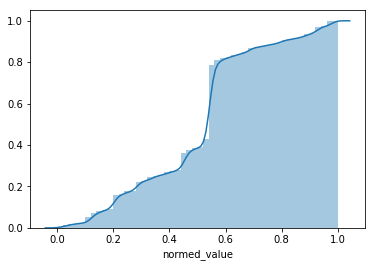

In [31]:
plot_cumul_all(df)

### plot all data

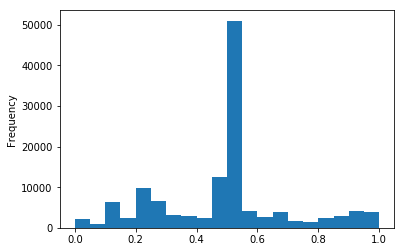

In [53]:
plot_all(df)

### plot one hour of a given day

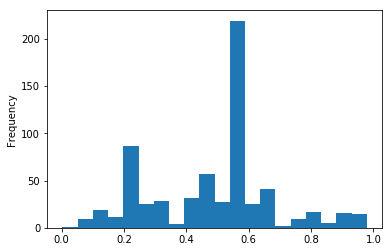

In [28]:
plot_one_hour(df)

### one plot per day, overlayed

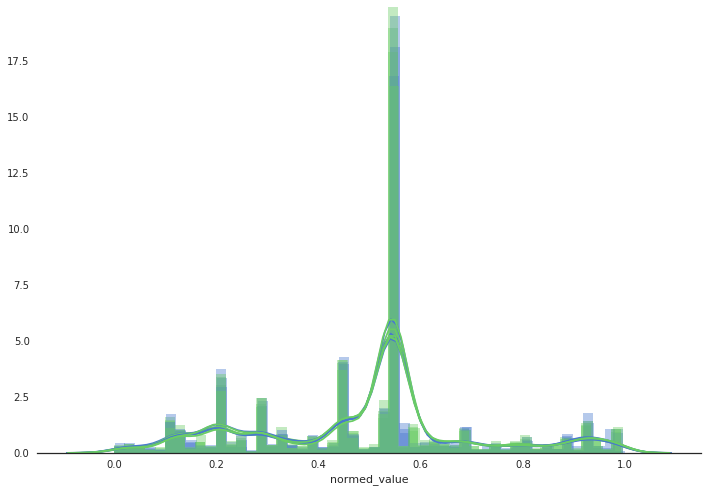

In [29]:
plot_one_per_day_overlay(df)

## distribution of numeric values

In [76]:
sql_prepare = ','.join([create_base_percentile(table, 'kwh'),
                        create_number_convert(),
                        create_stats()])

In [ ]:
df = pd.read_gbq(create_normed(sql_prepare),
                 dialect = 'standard',
                 project_id = gcp_project,
                 private_key = gcp_key)

In [78]:
df[:5]

,event_day,event_hour,raw_value,normed_value
0,20170910,19,780,0.378285
1,20170910,19,780,0.378285
2,20170910,19,780,0.378285
3,20170910,19,780,0.378285
4,20170910,19,780,0.378285


### quantiles

In [79]:
df.quantile(np.linspace(0.0, 1.0, num=11))

,event_hour,raw_value,normed_value
0.0,0.0,17.0,0.000000
0.1,2.0,62.0,0.022310
0.2,5.0,110.0,0.046108
0.3,8.0,165.0,0.073376
0.4,11.0,219.0,0.100149
0.5,13.0,255.0,0.117997
0.6,15.0,280.0,0.130392
0.7,17.0,377.0,0.178483
0.8,19.0,550.0,0.264254
0.9,21.0,845.0,0.410511


### plot all data

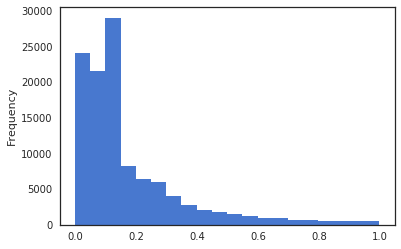

In [80]:
plot_all(df)

### plot one hour of a given day

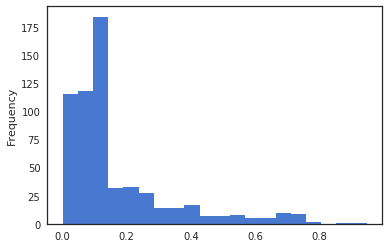

In [81]:
plot_one_hour(df)

### one plot per day, overlayed

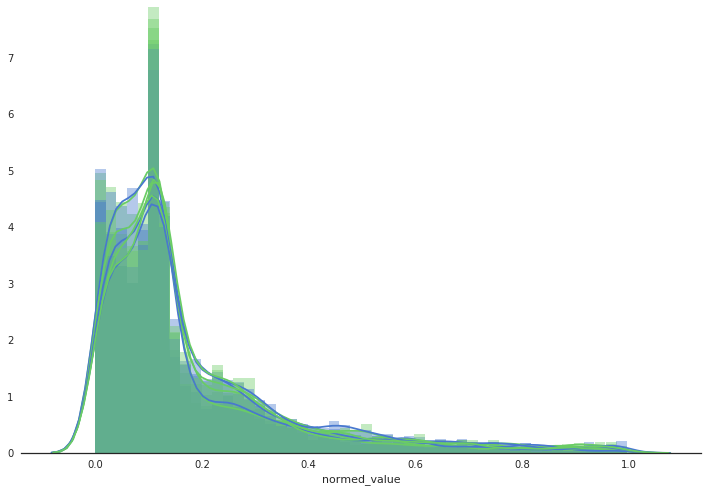

In [82]:
plot_one_per_day_overlay(df)

## distribution of time values

In [92]:
sql_prepare = ','.join([create_base_percentile(table, 'first_on_at'),
                        create_time_convert(),
                        create_stats()])

In [ ]:
df = pd.read_gbq(create_normed(sql_prepare),
                 dialect = 'standard',
                 project_id = gcp_project,
                 private_key = gcp_key)

In [94]:
df[:5]

,event_day,event_hour,raw_value,normed_value
0,20170909,9,1504261042,0.796229
1,20170909,9,1504261042,0.796229
2,20170909,12,1504261042,0.796229
3,20170909,9,1504261042,0.796229
4,20170909,13,1504261042,0.796229


### quantiles

In [95]:
df.quantile(np.linspace(0.0, 1.0, num=11))

,event_hour,raw_value,normed_value
0.0,0.0,1.501031e+09,0.000000
0.1,2.0,1.501854e+09,0.202717
0.2,5.0,1.502893e+09,0.458880
0.3,8.0,1.504024e+09,0.737680
0.4,11.0,1.504269e+09,0.798154
0.5,13.0,1.504355e+09,0.819431
0.6,15.0,1.504456e+09,0.844373
0.7,17.0,1.504547e+09,0.866613
0.8,19.0,1.504678e+09,0.899107
0.9,21.0,1.504822e+09,0.934556


### plot all data

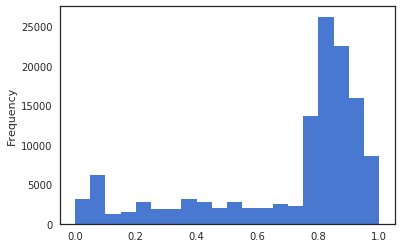

In [96]:
plot_all(df)

### plot one hour of a given day

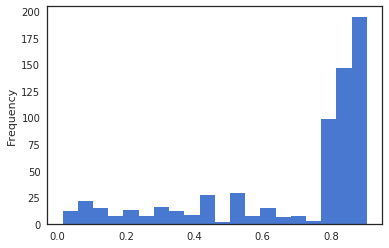

In [97]:
plot_one_hour(df)

### one plot per day, overlayed

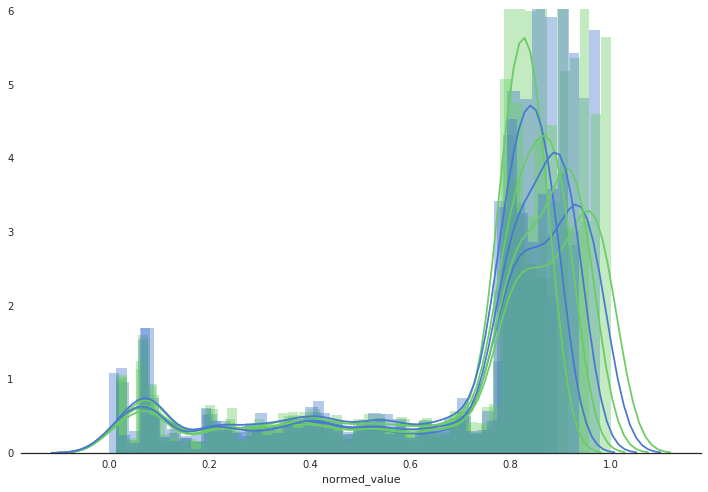

In [98]:
plot_one_per_day_overlay(df)

## distribution of bool values

In [110]:
sql_prepare = ','.join([create_base(table, 'generating'),
                        create_bool_convert(),
                        create_stats()])

In [ ]:
df = pd.read_gbq(create_normed(sql_prepare),
                 dialect = 'standard',
                 project_id = gcp_project,
                 private_key = gcp_key)

In [112]:
df[:5]

,event_day,event_hour,raw_value,normed_value
0,20170904,17,0.25,0.0
1,20170904,17,0.25,0.0
2,20170904,17,0.25,0.0
3,20170904,17,0.25,0.0
4,20170904,17,0.25,0.0


### quantiles

In [113]:
df.quantile(np.linspace(0.0, 1.0, num=11))

,event_hour,raw_value,normed_value
0.0,0.0,0.25,0.0
0.1,2.0,0.25,0.0
0.2,5.0,0.25,0.0
0.3,7.0,0.25,0.0
0.4,11.0,0.25,0.0
0.5,13.0,0.25,0.0
0.6,15.0,0.25,0.0
0.7,17.0,0.25,0.0
0.8,19.0,0.25,0.0
0.9,21.0,0.25,0.0


### plot all data

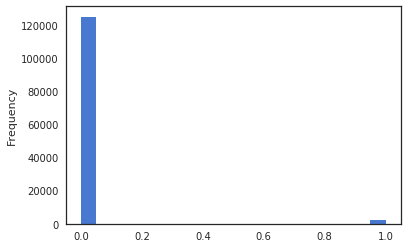

In [114]:
plot_all(df)

### plot one hour of a given day

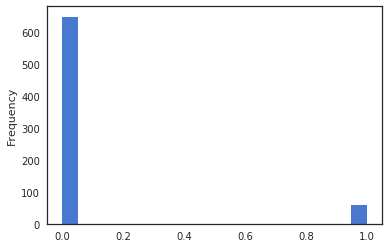

In [115]:
plot_one_hour(df)

### one plot per day, overlayed

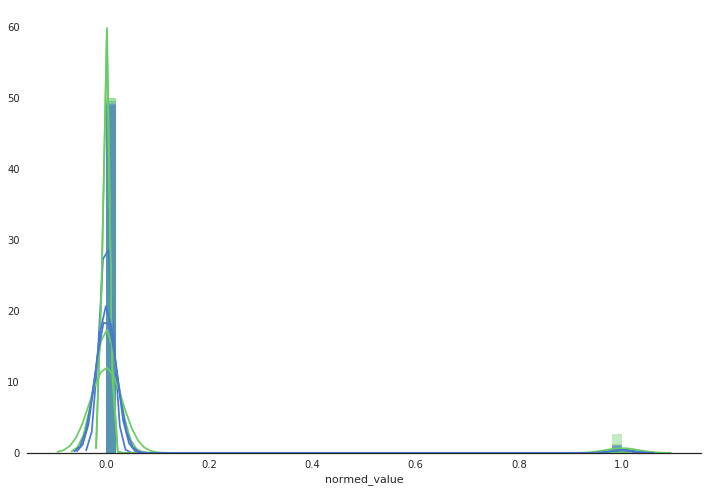

In [116]:
plot_one_per_day_overlay(df)

## distribution of "unique" values

In [ ]:
sql_prepare = ','.join([create_base(table, 'mill_signature'),
                        create_string_convert(-8),
                        create_stats()])

df = pd.read_gbq(create_normed(sql_prepare),
                 dialect = 'standard',
                 project_id = gcp_project,
                 private_key = gcp_key)

### quantiles

In [118]:
df.quantile(np.linspace(0.0, 1.0, num=11))

,event_hour,raw_value,normed_value
0.0,0.0,2.875702e+13,0.000000
0.1,2.0,1.196453e+17,0.103755
0.2,5.0,2.351351e+17,0.203931
0.3,7.0,3.503671e+17,0.303883
0.4,11.0,4.671947e+17,0.405220
0.5,13.0,5.901342e+17,0.511857
0.6,15.0,7.034651e+17,0.610161
0.7,17.0,8.163105e+17,0.708043
0.8,19.0,9.287558e+17,0.805578
0.9,21.0,1.044619e+18,0.906077


### plot all data

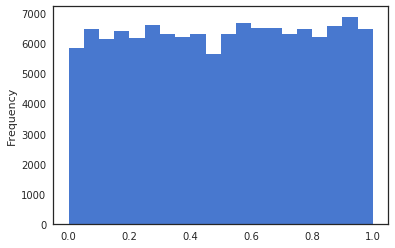

In [119]:
plot_all(df)

### plot one hour of a given day

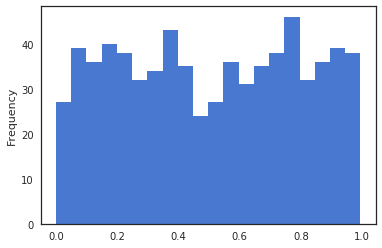

In [120]:
plot_one_hour(df)

### one plot per day, overlayed

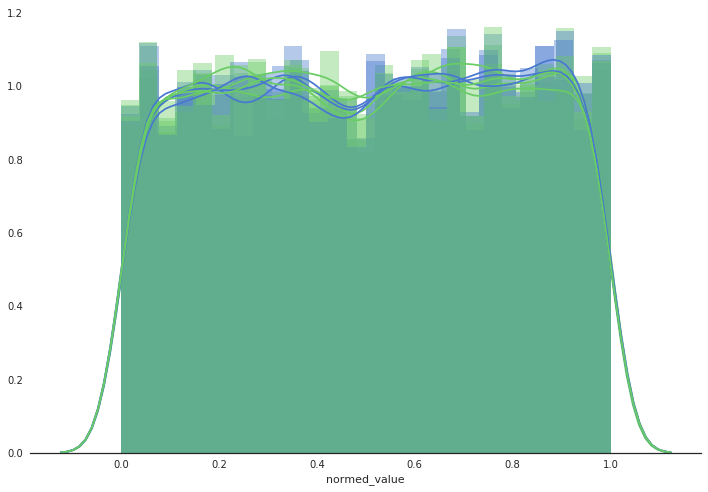

In [121]:
plot_one_per_day_overlay(df)

## distribution of categorial values

In [ ]:
sql_prepare = ','.join([create_base(table, 'country'),
                        create_string_convert(),
                        create_stats()])

df = pd.read_gbq(create_normed(sql_prepare),
                 dialect = 'standard',
                 project_id = gcp_project,
                 private_key = gcp_key)

### quantiles

In [123]:
df.quantile(np.linspace(0.0, 1.0, num=21))

,event_hour,raw_value,normed_value
0.00,0.0,2.142066e+16,0.000000
0.05,1.0,2.626681e+17,0.215406
0.10,2.0,2.817049e+17,0.232404
0.15,3.0,2.817049e+17,0.232404
0.20,5.0,2.817049e+17,0.232404
0.25,6.0,2.817049e+17,0.232404
0.30,7.0,2.817049e+17,0.232404
0.35,9.0,2.817049e+17,0.232404
0.40,11.0,2.817049e+17,0.232404
0.45,12.0,2.817049e+17,0.232404


### plot all data

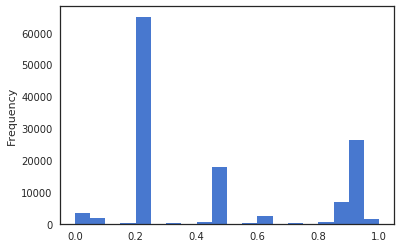

In [124]:
plot_all(df)

### plot one hour of a given day

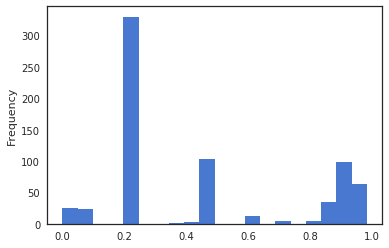

In [125]:
plot_one_hour(df)

### one plot per day, overlayed

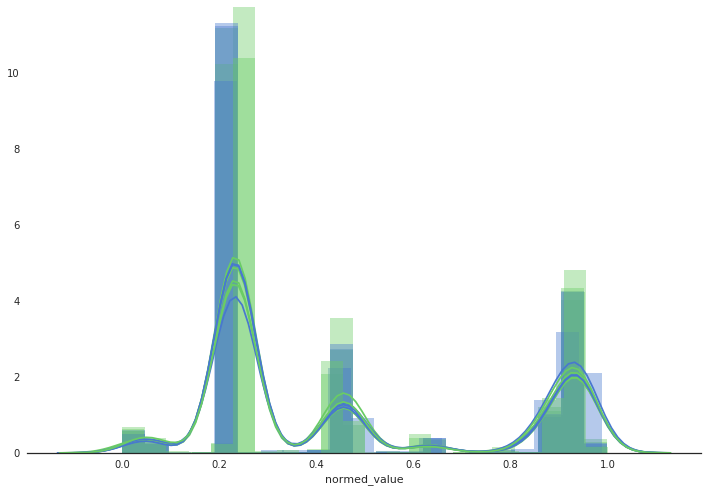

In [126]:
plot_one_per_day_overlay(df)